In [1]:
library(dplyr)
library(tidyr)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
df2017 <- read.csv('data\\NBA_PBP_2017-18.csv')
df2018 <- read.csv('data\\NBA_PBP_2018-19.csv')
df2019 <- read.csv('data\\NBA_PBP_2019-20.csv')

In [3]:
length(unique(df2017$SecLeft))

[1] 720

In [4]:
names(df2017)

[1] "URL"                "GameType"           "Location"          
 [4] "Date"               "Time"               "WinningTeam"       
 [7] "Quarter"            "SecLeft"            "AwayTeam"          
[10] "AwayPlay"           "AwayScore"          "HomeTeam"          
[13] "HomePlay"           "HomeScore"          "Shooter"           
[16] "ShotType"           "ShotOutcome"        "ShotDist"          
[19] "Assister"           "Blocker"            "FoulType"          
[22] "Fouler"             "Fouled"             "Rebounder"         
[25] "ReboundType"        "ViolationPlayer"    "ViolationType"     
[28] "TimeoutTeam"        "FreeThrowShooter"   "FreeThrowOutcome"  
[31] "FreeThrowNum"       "EnterGame"          "LeaveGame"         
[34] "TurnoverPlayer"     "TurnoverType"       "TurnoverCause"     
[37] "TurnoverCauser"     "JumpballAwayPlayer" "JumpballHomePlayer"
[40] "JumpballPoss"

In [6]:
# This function is used to clean the three df and leave 
# in a tidy format all data
cleanData <- function(df, vars, year){
    select_variables <- function(df, vars){
    
        # This function works to select all the data from lakers 
        # matchs, selecting by home or visit games.
        
        # Filter by variables
        df <- df[vars]
        
        # Select just the data from Lakers
        df <- df %>% 
            filter((HomeTeam == 'LAL') | (AwayTeam == 'LAL'))
        
        # Change values that are empty to NA in HomePlay and AwayPlay
        df$HomePlay <- ifelse(df$HomePlay == "", NA, df$HomePlay)
        df$AwayPlay <- ifelse(df$AwayPlay == "", NA, df$AwayPlay)
        
        # Make dummy variables in shotOutcome
        df$ShotOutcome <- ifelse(df$ShotOutcome == "make", 1, 0)
        
        # Use data from LAL and not from oppponent team
        df <- df[!(df$HomeTeam == "LAL" & !is.na(df$AwayPlay)), ]
        df <- df[!(df$AwayTeam == "LAL" & !is.na(df$HomePlay)), ]
        
        return (df)
    }

    make_shotDF <- function(df){
        # Change values that are empty to NA in ShotType
        df$ShotType <- ifelse(df$ShotType == "", NA, df$ShotType)
        
        # Leave just plays that are shot types
        df <- df[complete.cases(df$ShotType), ]
        
        # Separate ShotType to write the points and type of shot in different columns
        df <- separate(df, ShotType, into = c("Points", "Type"), sep = "-pt ")
        
        return (df)
    }
    
    add_range_timeLeft <- function(df){
        # Crear un marco de datos que contenga todos los valores de time_left de 0 a 2880
        all_time_left <- data.frame(Time_left = seq(0, 2880))
        
        # Realizar una unión (join) izquierda entre los datos originales y los valores completos de time_left
        result_df <- left_join(all_time_left, df, by = "Time_left")
        
        # Llenar los valores faltantes en Points, ShotDist, Type, y URL
        result_df$Points[is.na(result_df$Points)] <- 0
        result_df$ShotDist[is.na(result_df$ShotDist)] <- NA
        result_df$Type[is.na(result_df$Type)] <- NA
        result_df$URL[is.na(result_df$URL)] <- "/boxscores/201710190LAL.html"
        result_df$Team[is.na(result_df$Team)] <- "LAL"
        result_df$Year[is.na(result_df$Year)] <- year
        return(result_df)
        
    } 
    
    # Filter by gametype because we are interested in regular games only 
    df <- df %>% filter(GameType == 'regular')
    
    # Select data to use
    df <- select_variables(df, vars)
    
    # Leave all the data from Team in a single column
    df <- df %>%
        mutate(Team = ifelse(df$HomeTeam == "LAL", 'LAL', df$AwayTeam)) %>%
        select(-HomeTeam, -AwayTeam, -HomePlay, -AwayPlay)
    
    df <- make_shotDF(df)
    
    # Make a variable with time left in the match in seconds
    df$Time_left <- df$SecLeft * df$Quarter
    
    # Leave data in correct format
    df$Points <- as.integer(df$Points)
    
    # Delete innecesary columns
#    df <- df %>% select(-Quarter, -SecLeft)
    
    # Add year of the data
    df$Year <- year
    
    # Leave df ordered by columns
    vars_order <- c('Team', 'Year', 'URL', 'Quarter', 'Time_left', 'Type', 'Points', 'ShotDist', 'ShotOutcome')
    df <- df[vars_order]
    
  #  df <- add_range_timeLeft(df)
    
    return (df)   
}

In [18]:
vars <- c('URL', 'Quarter', 'HomeTeam', 'AwayTeam', 'SecLeft', 'HomePlay', 'AwayPlay',  'ShotType', 'ShotOutcome', 'ShotDist')

df_2017 <- cleanData(df2017, vars, 2017)
df_2018 <- cleanData(df2018, vars, 2018)
df_2019 <- cleanData(df2019, vars, 2019)

In [ ]:
df <- rbind(df_2017, df_2018)
df <- rbind(df, df_2019)

#df_dummy <- model.matrix(~ df$Type - 1, data = df_filtered)

# Unir las variables dummy al conjunto de datos original
#df_joined <- cbind(df, df_dummy)


df_joined <- df %>%
  group_by(Year, URL, Quarter) %>%
  summarize(
    time_left = mean(Time_left),
    shotdist = mean(ShotDist),
    jump_shot = sum(Type == "jump shot"),
    hook_shot = sum(Type == "hook shot"),
    layup = sum(Type == "layup"),
    dunk = sum(Type == "dunk"),
    two_points = sum(Points == 2),
    three_points = sum(Points == 3),
    outcome_0 = sum(ShotOutcome == 0),
    outcome_1 = sum(ShotOutcome == 1)
  )
df_joined

In [27]:
vars <- c('time_left', 'Year', 'Quarter', 'jump_shot', 'dunk', 'hook_shot', 'layup', 'two_points', 'three_points', 'shotdist', 'outcome_0', 'outcome_1')

df_filtered <- df_joined[vars]

In [82]:
df_filtered

time_left,Year,Quarter,jump_shot,dunk,hook_shot,layup,two_points,three_points,shotdist,outcome_0,outcome_1
<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>
354.1538,2017,1,15,4,2,5,22,4,10.961538,19,7
658.4545,2017,2,14,1,1,6,16,6,13.181818,12,10
1224.0000,2017,3,11,2,2,7,20,2,9.409091,13,9
1239.2381,2017,4,13,1,2,5,17,4,12.285714,10,11
374.6957,2017,1,15,1,0,7,15,8,12.260870,10,13
653.0000,2017,2,13,3,1,5,16,6,13.500000,12,10
1099.0000,2017,3,12,2,2,8,18,6,9.875000,10,14
1283.8261,2017,4,12,0,0,11,17,6,10.695652,12,11
341.6154,2017,1,17,1,1,7,19,7,13.461538,18,8


In [64]:
#install.packages("dbscan")

# Cargar el paquete
library(dbscan)

# Aplicar DBSCAN
resultados <- dbscan(df_filtered, eps = 120, minPts = 120)

# Visualizar los resultados del clustering
#colors <- as.character(resultados$cluster + 1)
#colors[resultados$cluster == 0] <- "black"  # Puntos de ruido en negro
#
#legend("topright", legend = unique(resultados$cluster), col = unique(colors), pch = 16, title = "Cluster")
#
#plot(df_filtered$Type, df_filtered$ShotDist, col = colors, pch = 16, main = "DBSCAN Clustering")
names(resultados)

[1] "cluster"      "eps"          "minPts"       "dist"         "borderPoints"

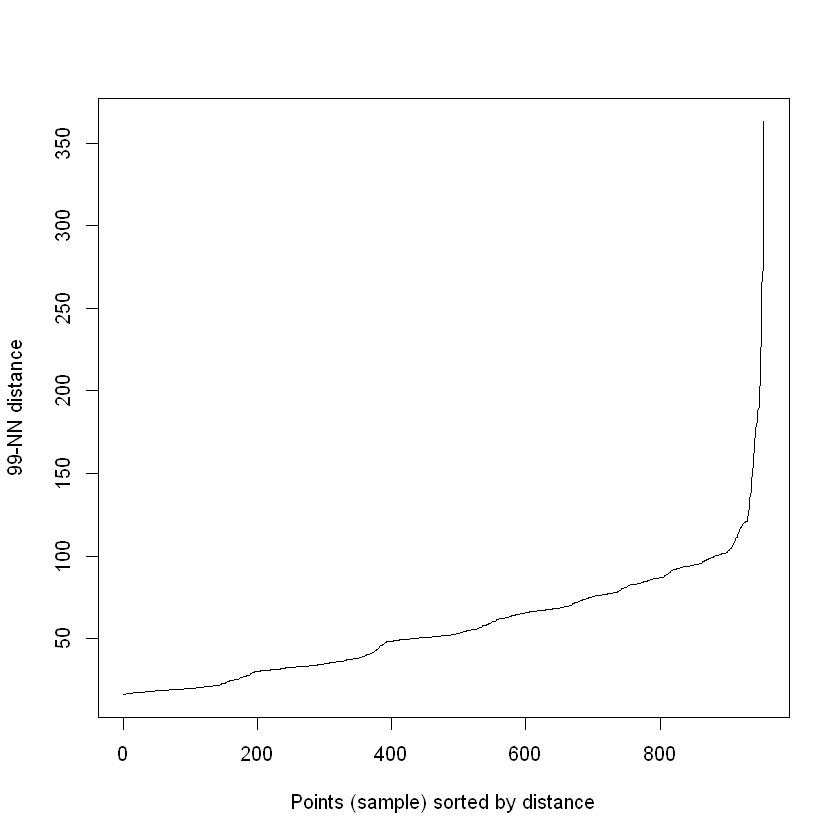

In [79]:
kNNdistplot(df_filtered, minPts = 100)

In [76]:
?dbscan

dbscan {dbscan},R Documentation
x,"a data matrix, a data.frame, a dist object or a frNN object with fixed-radius nearest neighbors."
eps,size (radius) of the epsilon neighborhood. Can be omitted if x is a frNN object.
minPts,number of minimum points required in the eps neighborhood for core points (including the point itself).
weights,numeric; weights for the data points. Only needed to perform weighted clustering.
borderPoints,"logical; should border points be assigned to clusters. The default is TRUE for regular DBSCAN. If FALSE then border points are considered noise (see DBSCAN* in Campello et al, 2013)."
...,additional arguments are passed on to the fixed-radius nearest neighbor search algorithm. See frNN() for details on how to control the search strategy.
object,clustering object.
newdata,new data points for which the cluster membership should be predicted.
data,the data set used to create the clustering object.
eps,value of the eps parameter.


In [75]:
resultados$dist

[1] "euclidean"

In [ ]:
for (eps_ in 1:1000){
    for (minPts_)
} 

In [74]:
table(resultados$cluster)[1]

0 
6

DBSCAN clustering for 20940 objects.
Parameters: eps = 5, minPts = 90
Using euclidean distances and borderpoints = TRUE
The clustering contains 3 cluster(s) and 20456 noise points.

    0     1     2     3 
20456   227   130   127 

Available fields: cluster, eps, minPts, dist, borderPoints